## Cameron Bale
***
#### Code for pre-processing the location data for South Korean COVID-19 patients.
***

In [1]:
from pyproj import Proj
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

First, we create a coordinate reference system for locations in Korea measured in meters.

In [2]:
p = Proj("epsg:5179")

In [3]:
p.crs

<Projected CRS: EPSG:5179>
Name: KGD2002 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Now, we import the data. `PatientRoute.csv` contains patient ID and various corresponding latitude and longitude measurements. `PatientInfo.csv` contains some patient information such as their year of birth (can be used to infer age), gender, and whether the person was deceased.

In [4]:
routes = pd.read_csv("../Data/SK/PatientRoute.csv")
info = pd.read_csv("../Data/SK/PatientInfo.csv")

We merge the patient information to the locations, and take only the subset of variables we are interested in.

In [5]:
X = pd.merge(routes, info, how = "left", on = "patient_id")[["latitude", "longitude", "sex", "age", "state"]]

For simplicity, we drop observations with missing values (alternatively, these could be imputed).

In [6]:
X = X.dropna()

We convert the state variable to a binary variable.

In [7]:
new_state = (X["state"] == "deceased").astype(int)

In [8]:
X = X.assign(state=new_state).reset_index(drop=True)

We can check the minimum and maximum `latitude` and `longitude` values; and they fall within the boundaries of the coordinate reference system defined above.

In [9]:
X.describe()

,latitude,longitude,state
count,6712.000000,6712.000000,6712.000000
mean,36.753985,127.633289,0.008194
std,0.914046,0.900125,0.090157
min,33.454642,126.301005,0.000000
25%,35.891794,126.939025,0.000000
50%,37.331956,127.110486,0.000000
75%,37.514121,128.500770,0.000000
max,38.193169,129.475746,1.000000


We perform the projection from latitude and longitude to meters for the patient locations.

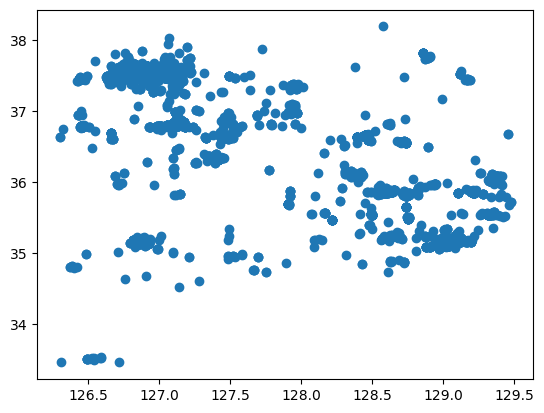

In [10]:
plt.scatter(X["longitude"], X["latitude"])
plt.show()

In [11]:
lons, lats = p(X["longitude"], X["latitude"])

In [12]:
new_locs = pd.DataFrame([lats, lons]).T

In [13]:
new_locs.columns = ["latitude", "longitude"]

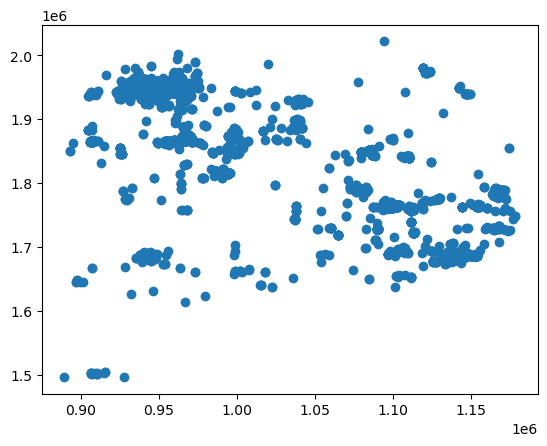

In [14]:
plt.scatter(new_locs["longitude"], new_locs["latitude"])
plt.show()

We will standardize the location measurements. Overall, we will treat `latitude`, `longitude`, as continuous, and `state`, as categorical.

In [15]:
# standardize location measurements
means = np.mean(new_locs[["latitude", "longitude"]], axis = 0)
stds = np.std(new_locs[["latitude", "longitude"]], axis = 0)
new_locs[["latitude", "longitude"]] = (new_locs[["latitude", "longitude"]]-means)/stds

standardization_stats = pd.DataFrame({"means":means, "stds":stds})

In [16]:
means

latitude     1.862157e+06
longitude    1.012614e+06
dtype: float64

In [17]:
stds

latitude     101089.342153
longitude     80975.132079
dtype: float64

In [18]:
standardization_stats

,means,stds
latitude,1.862157e+06,101089.342153
longitude,1.012614e+06,80975.132079


In [19]:
X = X.assign(longitude=new_locs.longitude, latitude=new_locs.latitude)

Convert age to numeric.

In [20]:
cat_columns = X.select_dtypes(['object']).columns

In [21]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.astype('category'))

In [22]:
categories = X[cat_columns].apply(lambda x: x.cat.categories)

In [23]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)

In [24]:
categories

sex            Index(['female', 'male'], dtype='object')
age    Index(['0s', '10s', '20s', '30s', '40s', '50s'...
dtype: object

In [25]:
X.to_csv("../Data/SK/cleaned_sk_data.csv", index = False)
standardization_stats.to_csv("../Data/SK/sk_standardization_stats.csv", index = False)